<a href="https://colab.research.google.com/github/e-c-centric/Group26_Final_Project/blob/main/Group26_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textstat langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 997.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.7 MB/s eta 0:00:00
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=d726006015a8bb984a037fe1184de4fc47241d1b06f8477d6780ede54245ab15
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from google.colab import drive
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
import random
import textstat
import langid
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


**Data Collection**

In [4]:
'''This file was sourced from the Oxford DIctionary. We stripped all the word definitions from the list'''

file_path = '/content/drive/MyDrive/Colab Notebooks/words.txt'

with open(file_path, 'r') as file:
    words = file.read().split()

'''We preprocessed our list of words to remove all words of length less than 3. We also removed
words that contain numbers'''

refined_words = [word for word in words if word.isalpha() and len(word) >= 3]

with open('/content/drive/MyDrive/Colab Notebooks/application_words.txt', 'w') as file:
    file.write('\n'.join(refined_words))

random_sample = random.sample(refined_words, 1000)#creating a subset for training
with open('/content/drive/MyDrive/Colab Notebooks/training_words.txt', 'w') as file:
    file.write('\n'.join(random_sample))

In [5]:
file_path = '/content/drive/MyDrive/Colab Notebooks/training_words.txt'
training_df = pd.read_csv(file_path, sep= " ", names=['word'])
training_df = training_df.dropna()

file_path = '/content/drive/MyDrive/Colab Notebooks/application_words.txt'
application_df = pd.read_csv(file_path, sep= " ", names=['word'])
application_df = application_df.dropna()

In [6]:
from gensim.models import Word2Vec
#import gensim.downloader as api
#model_name = "word2vec-google-news-300"
#word2vec_model = api.load(model_name)
#training a Word2Vec word embedding model on our application df'''
word2vec_model = Word2Vec(sentences=[application_df['word'].tolist()], vector_size=100, window=5, min_count=1, workers=4)
def word_to_vec(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return None

In [7]:
training_df.info

<bound method DataFrame.info of                 word
0            Porella
1           thrivers
2              exing
3    unflinchingness
4      indominitable
..               ...
995          stodger
996          outgush
997        azocyclic
998       gismondite
999          Laspisa

[1000 rows x 1 columns]>

In [8]:
application_df.info

<bound method DataFrame.info of                 word
0                AAA
1               AAAA
2             AAAAAA
3               AAAL
4               AAAS
...              ...
415696  zwitterionic
415697        Zwolle
415698      Zworykin
415699           zZt
415700           ZZZ

[415700 rows x 1 columns]>

**Feature Extraction and Augmentation**

In [9]:
def extract_features(word):
    try:
        syllables = textstat.syllable_count(word)
        ari = textstat.automated_readability_index(word)
        length = len(word)
        #language, _ = langid.classify(word)

        return {'syllables': syllables, 'ari': ari, 'length': length, 'language': None}
    except Exception as e:
        print(f"Error extracting features for '{word}': {e}")
        return None


feature_columns = ['ari','length']
for column in feature_columns:
    training_df[column] = training_df['word'].apply(lambda word: extract_features(word)[column] if extract_features(word) else None)

# Drop rows with missing features
training_df = training_df.dropna(subset=feature_columns)

In [10]:
training_df.tail()

,word,ari,length
995,stodger,12.0,7
996,outgush,12.0,7
997,azocyclic,21.5,9
998,gismondite,26.2,10
999,Laspisa,12.0,7


In [11]:
'''unique_elements = training_df['language'].unique()

print(unique_elements)'''

"unique_elements = training_df['language'].unique()\n\nprint(unique_elements)"

In [12]:
'''label_encoder = LabelEncoder()
training_df['language'] = label_encoder.fit_transform(training_df['language'])'''

"label_encoder = LabelEncoder()\ntraining_df['language'] = label_encoder.fit_transform(training_df['language'])"

In [13]:
training_df['word_vector'] = training_df['word'].apply(word_to_vec)

training_df = training_df.dropna(subset=['word_vector'])

**Scaling**

In [14]:
scaler = StandardScaler()

X_train_word_vector = np.stack(training_df['word_vector'].to_numpy())
X_train_other_features = scaler.fit_transform(training_df[feature_columns])

X_train = np.concatenate((X_train_word_vector, X_train_other_features), axis=1)

In [15]:
training_df

,word,ari,length,word_vector
0,Porella,12.0,7,"[-0.0069386913, 0.0011353147, -0.009583937, -0..."
1,thrivers,16.8,8,"[0.002854986, 0.009943634, -0.007242663, 0.000..."
2,exing,2.6,5,"[0.0015490305, -0.000110555884, 0.006903529, 0..."
3,unflinchingness,49.7,15,"[0.005862644, -0.0032035327, 0.0073452713, -0...."
4,indominitable,40.3,13,"[0.0018190086, -0.004042928, 0.009658239, 0.00..."
...,...,...,...,...
995,stodger,12.0,7,"[-0.00061559794, -0.0030927574, -0.0064616264,..."
996,outgush,12.0,7,"[-0.0061649573, 0.0021129549, 0.0020104456, 0...."
997,azocyclic,21.5,9,"[0.0049388455, -0.0058035515, 0.00028217674, -..."
998,gismondite,26.2,10,"[-0.0043173158, 0.0007054496, -0.0011967111, -..."


In [16]:
X_train

array([[-6.93869125e-03,  1.13531470e-03, -9.58393700e-03, ...,
         1.39958260e-03, -7.46004511e-01, -7.43253294e-01],
       [ 2.85498612e-03,  9.94363427e-03, -7.24266283e-03, ...,
         1.48275378e-03, -3.89341863e-01, -3.92992552e-01],
       [ 1.54903054e-03, -1.10555884e-04,  6.90352917e-03, ...,
         2.46844301e-03, -1.44446886e+00, -1.44377478e+00],
       ...,
       [ 4.93884552e-03, -5.80355152e-03,  2.82176741e-04, ...,
        -3.37499147e-03, -4.01096870e-02, -4.27318105e-02],
       [-4.31731576e-03,  7.05449609e-04, -1.19671109e-03, ...,
        -5.69242472e-03,  3.09122489e-01,  3.07528931e-01],
       [-9.22361622e-04, -8.08867218e-04, -6.56895991e-03, ...,
        -2.50147568e-04, -7.46004511e-01, -7.43253294e-01]])

**Using the Elbow Method to find the optimal number of clusters**

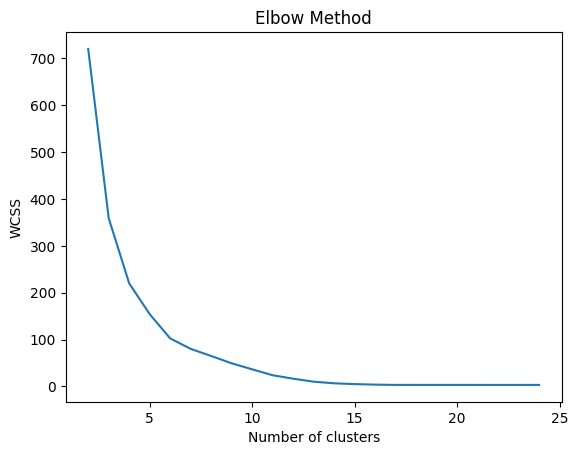

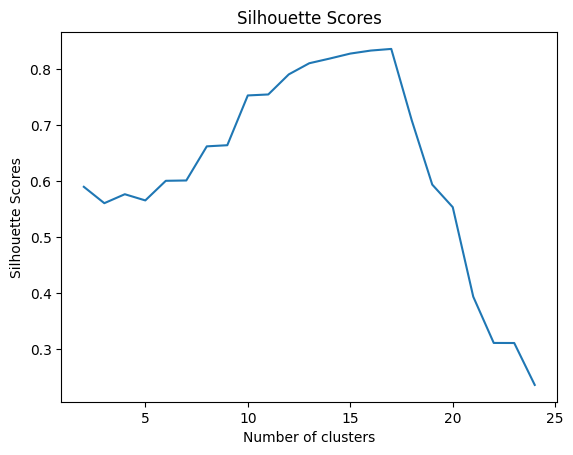

In [20]:
wcss = []
silhouette_scores = []

for i in range(2, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_train, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(2, 25), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.show()

optimal_clusters = 16

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
training_df['cluster'] = kmeans.fit_predict(X_train)

In [21]:
training_df

,word,ari,length,word_vector,cluster
0,Porella,12.0,7,"[-0.0069386913, 0.0011353147, -0.009583937, -0...",7
1,thrivers,16.8,8,"[0.002854986, 0.009943634, -0.007242663, 0.000...",3
2,exing,2.6,5,"[0.0015490305, -0.000110555884, 0.006903529, 0...",9
3,unflinchingness,49.7,15,"[0.005862644, -0.0032035327, 0.0073452713, -0....",13
4,indominitable,40.3,13,"[0.0018190086, -0.004042928, 0.009658239, 0.00...",10
...,...,...,...,...,...
995,stodger,12.0,7,"[-0.00061559794, -0.0030927574, -0.0064616264,...",7
996,outgush,12.0,7,"[-0.0061649573, 0.0021129549, 0.0020104456, 0....",7
997,azocyclic,21.5,9,"[0.0049388455, -0.0058035515, 0.00028217674, -...",4
998,gismondite,26.2,10,"[-0.0043173158, 0.0007054496, -0.0011967111, -...",0


In [22]:
#A Silhouette Score between 0.7 to 1 indicates clusters are well formed and distinct from other clusters
silhouette_avg = silhouette_score(X_train, training_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.83362330284984


In [23]:
def predict_cluster(word):
    # Extract features for the word (similar to the preprocessing steps during training)
    word_vector = word_to_vec(word)
    features = extract_features(word)
    ari = features['ari']
    length = features['length']
    #lang = features['language']
    features=[ari,length]
    '''print(f"Word Vector: {word_vector}")
    print(f"Features: {features}")'''

    # Check if any feature is None (indicating an issue with feature extraction)
    if None in features or word_vector is None:
        print(f"Error extracting features for '{word}'. Unable to predict the cluster.")
        return None

    # Concatenate features
    input_features = np.concatenate([word_vector, features])
    input_features = input_features.reshape(1, -1)


    # Predict the cluster
    predicted_cluster = kmeans.predict(input_features)

    return predicted_cluster[0]


word_to_predict = "noise"
predicted_cluster = predict_cluster(word_to_predict)

if predicted_cluster is not None:
    print(f"The predicted cluster for '{word_to_predict}' is: {predicted_cluster}")
else:
    print("Unable to predict the cluster.")


The predicted cluster for 'noise' is: 5


In [24]:
random_words = application_df['word'].sample(n=4, random_state=42)

print("Random Words:")
print(random_words)

Random Words:
92233     depersonalization
111743              empower
54319         carbosilicate
114641          entreatment
Name: word, dtype: object


In [25]:
type(random_words)

pandas.core.series.Series

In [26]:
!pip install gtts pydub

In [27]:
random_words = random_words.tolist()
random_words

['depersonalization', 'empower', 'carbosilicate', 'entreatment']

In [28]:
index = random.randint(0,3)
word = random_words[index]
word

'carbosilicate'

In [29]:
from gtts import gTTS
import IPython.display as ipd
import io


print(f"\nWord {index + 1}: {word}")

# Generate the pronunciation using gTTS
tts = gTTS(text=word, lang='en', slow=False)

# Save the audio to a BytesIO object
audio_buffer = io.BytesIO()
tts.write_to_fp(audio_buffer)

# Play the audio in the notebook
ipd.display(ipd.Audio(audio_buffer.getvalue(), autoplay=True))

# Track the index of the pronounced word
print(f"The index of the pronounced word is: {index + 1}")



Word 3: carbosilicate


The index of the pronounced word is: 3


In [30]:
cluster_of_random_word = predict_cluster(word)

In [31]:
print(f"Cluster of Random Word: {cluster_of_random_word}")

words_in_same_cluster = application_df[application_df['word'].apply(predict_cluster) == cluster_of_random_word]

# Select 4 random words from the same cluster
random_words_from_same_cluster = words_in_same_cluster['word'].sample(n=4, random_state=42)

Cluster of Random Word: 12


In [32]:
random_words_from_same_cluster = random_words_from_same_cluster.tolist()
index = random.randint(0,3)
word = random_words_from_same_cluster[index]
word

'canticle'

In [33]:
tts = gTTS(text=word, lang='en', slow=False)

audio_buffer = io.BytesIO()
tts.write_to_fp(audio_buffer)

ipd.display(ipd.Audio(audio_buffer.getvalue(), autoplay=True))

print(f"The index of the pronounced word is: {index + 1}")


The index of the pronounced word is: 2


In [34]:
cluster_of_random_word = predict_cluster(word)
cluster_of_random_word

12

In [35]:
import time
stored_clusters = []

def play_round():
    random_words = application_df['word'].sample(n=4)
    random_words = random_words.tolist()
    index = random.randint(0,3)
    word_to_pronounce = random_words[index]

    print(f"\nListen to the word")
    tts = gTTS(text=word_to_pronounce, lang='en', slow=False)
    tts.save('pronunciation.mp3')
    ipd.display(ipd.Audio('pronunciation.mp3', autoplay=True), metadata=dict(rate=44100))
    time.sleep(2)


    print("\nSelect the correct option by index:")
    for index, word in enumerate(random_words):
        print(f"{index + 1}. {word}")

    user_input = int(input("Enter the index of the correct option: "))

    if user_input == index + 1:
        print("Correct!!")
    elif user_input == index + 1:
        cluster_of_incorrect_word = predict_cluster(word_to_pronounce)
        print(f"Incorrect! Predicted cluster of the incorrectly selected word: {cluster_of_incorrect_word}")
        stored_clusters.append(cluster_of_incorrect_word)


for _ in range(5):
    play_round()


print("\nStored clusters:", stored_clusters)
print("Use these clusters to regulate the randomization in future iterations.")


Listen to the word



Select the correct option by index:
1. marse
2. overfactitious
3. Thorsten
4. overvaluation
Enter the index of the correct option: 3

Listen to the word



Select the correct option by index:
1. thecitis
2. oleaster
3. crig
4. portiones
Enter the index of the correct option: 4
Correct!!

Listen to the word



Select the correct option by index:
1. octaemera
2. prepossessions
3. kything
4. polysomitic
Enter the index of the correct option: 1

Listen to the word



Select the correct option by index:
1. tinguaite
2. tithonias
3. diphtherotoxin
4. reabuse
Enter the index of the correct option: 4
Correct!!

Listen to the word



Select the correct option by index:
1. phimosis
2. Agamedes
3. acetylmethylcarbinol
4. presuspension
Enter the index of the correct option: 1

Stored clusters: []
Use these clusters to regulate the randomization in future iterations.


In [36]:
for i in range(5):
    random_words = application_df['word'].sample(n=4)
    random_words = random_words.tolist()
    index = random.randint(0,3)
    word_to_pronounce = random_words[index]
    print(word_to_pronounce)

Arnie
disported
impship
distressfulness
letterhead


In [37]:
stored_clusters = []
def play_round():
    random_words = application_df['word'].sample(n=4)
    random_words = random_words.tolist()
    index = random.randint(0, 3)
    word_to_pronounce = random_words[index]

    print(f"\nListen to the word: {word_to_pronounce}")
    tts = gTTS(text=word_to_pronounce, lang='en', slow=False)
    tts.save('pronunciation.mp3')
    ipd.display(ipd.Audio('pronunciation.mp3', autoplay=True), metadata=dict(rate=44100))
    time.sleep(3)

    print("\nSelect the correct option by index:")
    for i, word in enumerate(random_words):
        print(f"{i + 1}. {word}")

    user_input = int(input("Enter the index of the correct option: "))

    print(f"User input: {user_input}")
    print(f"Correct index: {index + 1}")

    if user_input == index + 1:
        print("Correct!!")
    elif user_input == index + 1:
        cluster_of_incorrect_word = predict_cluster(word_to_pronounce)
        print(f"Incorrect! Predicted cluster of the incorrectly selected word: {cluster_of_incorrect_word}")
        stored_clusters.append(cluster_of_incorrect_word)


for _ in range(5):
    play_round()

print("\nStored clusters:", stored_clusters)
print("Use these clusters to regulate the randomization in future iterations.")



Listen to the word: oblocutor



Select the correct option by index:
1. Cormick
2. Hatia
3. oblocutor
4. bassets
Enter the index of the correct option: 3
User input: 3
Correct index: 3
Correct!!

Listen to the word: ablend



Select the correct option by index:
1. ablend
2. blissing
3. albuminiform
4. semihobo
Enter the index of the correct option: 1
User input: 1
Correct index: 1
Correct!!

Listen to the word: blissful



Select the correct option by index:
1. Mylodon
2. eugenist
3. blissful
4. miscreant
Enter the index of the correct option: 3
User input: 3
Correct index: 3
Correct!!

Listen to the word: monetary



Select the correct option by index:
1. unconfinedly
2. scene
3. Blattariae
4. monetary
Enter the index of the correct option: 4
User input: 4
Correct index: 4
Correct!!

Listen to the word: toughed



Select the correct option by index:
1. Eutopian
2. toughed
3. steeplelike
4. Brotula
Enter the index of the correct option: 2
User input: 2
Correct index: 2
Correct!!

Stored clusters: []
Use these clusters to regulate the randomization in future iterations.


In [38]:
import joblib
joblib.dump(kmeans, '/content/drive/MyDrive/Colab Notebooks/kmeans_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/kmeans_model.pkl']